In [136]:
# %conda install -y openjdk
# %conda install -y pyspark
# %conda install -y -c conda-forge findspark

In [137]:
from pyspark.ml.regression import FMRegressor
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.datasets import fetch_california_housing
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

In [138]:
# start spark session
spark = SparkSession.builder.appName("FMRegressor Example").getOrCreate()

### Preparing the data

In [139]:
housing = fetch_california_housing()
print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [140]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [141]:
# convert dataset into a spark dataframe
df_pandas = DataFrame(housing.data, columns=housing.feature_names)
df_pandas['target'] = Series(housing.target)
df = spark.createDataFrame(df_pandas)
df.printSchema()

root
 |-- MedInc: double (nullable = true)
 |-- HouseAge: double (nullable = true)
 |-- AveRooms: double (nullable = true)
 |-- AveBedrms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- AveOccup: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- target: double (nullable = true)



In [142]:
print("Number of columns:", len(df.columns))
df.show(5)

Number of columns: 9
+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|target|
+------+--------+------------------+------------------+----------+------------------+--------+---------+------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23| 4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22| 3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24| 3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25| 3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25| 3.422|
+------+--------+------------------+------------------+----------+-----------------

In [143]:
# merge feature columns into a vector column
features = housing.feature_names
va = VectorAssembler(inputCols = features, outputCol='features')

va_df = va.transform(df)
va_df = va_df.select(['features', 'target'])
va_df.show(5)

+--------------------+------+
|            features|target|
+--------------------+------+
|[8.3252,41.0,6.98...| 4.526|
|[8.3014,21.0,6.23...| 3.585|
|[7.2574,52.0,8.28...| 3.521|
|[5.6431,52.0,5.81...| 3.413|
|[3.8462,52.0,6.28...| 3.422|
+--------------------+------+
only showing top 5 rows



In [144]:
# train-test split
(train, test) = va_df.randomSplit([0.8, 0.2])

### Training and testing

In [145]:
# train
fmr = FMRegressor(labelCol="target", stepSize=0.001)
fmr = fmr.fit(train)

print(fmr) 
print("Coefficients: ", fmr.linear)
print("Intercept: ", fmr.intercept)

FMRegressionModel: uid=FMRegressor_59316aa19a8e, numFeatures=8, factorSize=8, fitLinear=true, fitIntercept=true
Coefficients:  [0.0076639898001927475,0.0050037281928728685,0.006055235947263801,0.004420033544912233,-0.0012878488338912608,0.00411497184741709,0.0037373694232905414,-0.003735614859837849]
Intercept:  0.0037117281867064048


In [146]:
# predict
pred = fmr.transform(test)
pred.show(5) 

+--------------------+------+------------------+
|            features|target|        prediction|
+--------------------+------+------------------+
|[0.75,52.0,2.8235...| 1.625|1.5823442098080722|
|[0.76,10.0,2.6515...| 1.625|1.0599606395820422|
|[0.7683,38.0,4.25...| 0.818|1.9243147321449925|
|[0.8075,52.0,2.49...| 1.375|1.7010795679158286|
|[0.9241,17.0,2.81...| 1.775| 1.453958533179955|
+--------------------+------+------------------+
only showing top 5 rows



In [147]:
# evaluate prediction
rmse = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(pred)
mae = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(pred)
r2 = RegressionEvaluator(labelCol="target", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(pred)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

RMSE:  1.6123073655624311
MAE:  1.1839503911950933
R-squared:  -0.9054346924505865


### Vizualizing the results

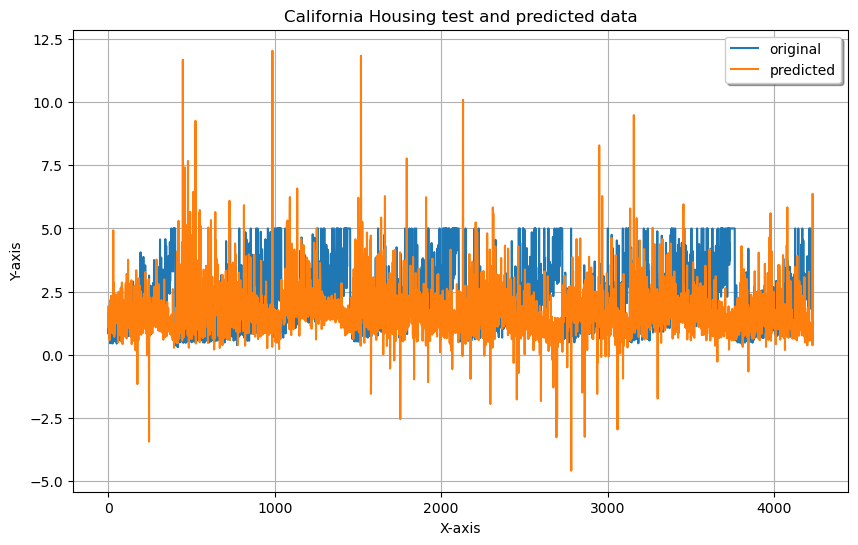

In [148]:
x_ax = range(0, pred.count())
y_pred=pred.select("prediction").collect()
y_orig=pred.select("target").collect()

plt.figure(figsize=(10,6))
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("California Housing test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [149]:
# stop session 
spark.stop()